In [198]:
import sys
sys.path.append('..')
import fit_field_line_null
reload(fit_field_line_null)
from fit_field_line_null import find_field_null
import numpy as np

from write_to_vtk.read_unstructured_vtk import read_unstructured_vtk
from write_to_vtk import structured_3d_vtk as struc_3d

from scipy import ndimage

from centroid_fitting import gyration_path
reload(gyration_path)
gyration_path = gyration_path.gyration_path

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')

from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as axisartist
import matplotlib.patches as patches

In [67]:
def get_interpolations(time_point):
    in_dir = ('../../output/filtered_unstructured_measurements/' + 
              '2017-04-17-16-44' + '/')
    in_file = '_filtered_unstructured_'

    centroids = []


    bxby_extents = {0: [-0.027, 0.025, -0.057, 0.040, 0.249, 0.416],
                    1: [-0.027, 0.027, -0.073, 0.041, 0.249, 0.416],
                    2: [-0.047, 0.031, -0.021, 0.028, 0.249, 0.416],
                    3: [-0.061, 0.031, -0.026, 0.03,  0.249, 0.416]}
    bz_extents = {0: [-0.027, 0.025, -0.06, 0.041, 0.249, 0.416],
                  1: [-0.27, 0.027, -0.076, 0.041, 0.249, 0.416],
                  2: [-0.044, 0.031, -0.021, 0.03, 0.249, 0.416],
                  3: [-0.072, 0.031, -0.026, 0.03, 0.249, 0.416]}

    bxby_extent = bxby_extents[0]
    bz_extent = bz_extents[0]



    time_str = str(time_point).zfill(4)
    bx_points, bx_values = read_unstructured_vtk(in_dir + 'bx' +
                                                 in_file + time_str + '.vtk')
    by_points, by_values = read_unstructured_vtk(in_dir + 'by' +
                                                 in_file + time_str + '.vtk')
    #bz_points, bz_values = read_unstructured_vtk(in_dir + 'bz' +
    #                                             in_file + time_str + '.vtk')
    print np.unique(bx_points[:, 2])
    z_value = np.unique(bx_points[:, 2])[0]
    print z_value
    
    z_index = np.where(bx_points[:, 2] == z_value)[0]
    bx_points = bx_points[z_index, :-1]
    bx_values = bx_values[z_index]
    z_index = np.where(by_points[:, 2] == z_value)[0]
    by_points = by_points[z_index, :-1]
    by_values = by_values[z_index]
    #z_index = np.where(bz_points[:, 2] == z_value)[0]
    #bz_points = bz_points[z_index, :-1]
    #bz_values = bz_values[z_index]

    bx_interpolator = struc_3d.get_interpolator(bx_points, bx_values)
    by_interpolator = struc_3d.get_interpolator(by_points, by_values)
    #bz_interpolator = struc_3d.get_interpolator(bz_points, bz_values)
    grid_extent = [bxby_extent[0], bxby_extent[1],
                   bxby_extent[2], bxby_extent[3]]
    grid = np.meshgrid(np.linspace(grid_extent[0], grid_extent[1],
                                   (grid_extent[1] - grid_extent[0])/
                                    0.001),
                       np.linspace(grid_extent[2], grid_extent[3],
                                   (grid_extent[3] - grid_extent[2])/
                                    0.001))
    return grid, bx_interpolator, by_interpolator

In [68]:
(grid, bx_interpolator, 
 by_interpolator) = get_interpolations(0)

[ 0.419]
0.418999999762


In [69]:
bx = bx_interpolator(grid[0][:, :], grid[1][:, :])
by = by_interpolator(grid[0][:, :], grid[1][:, :])

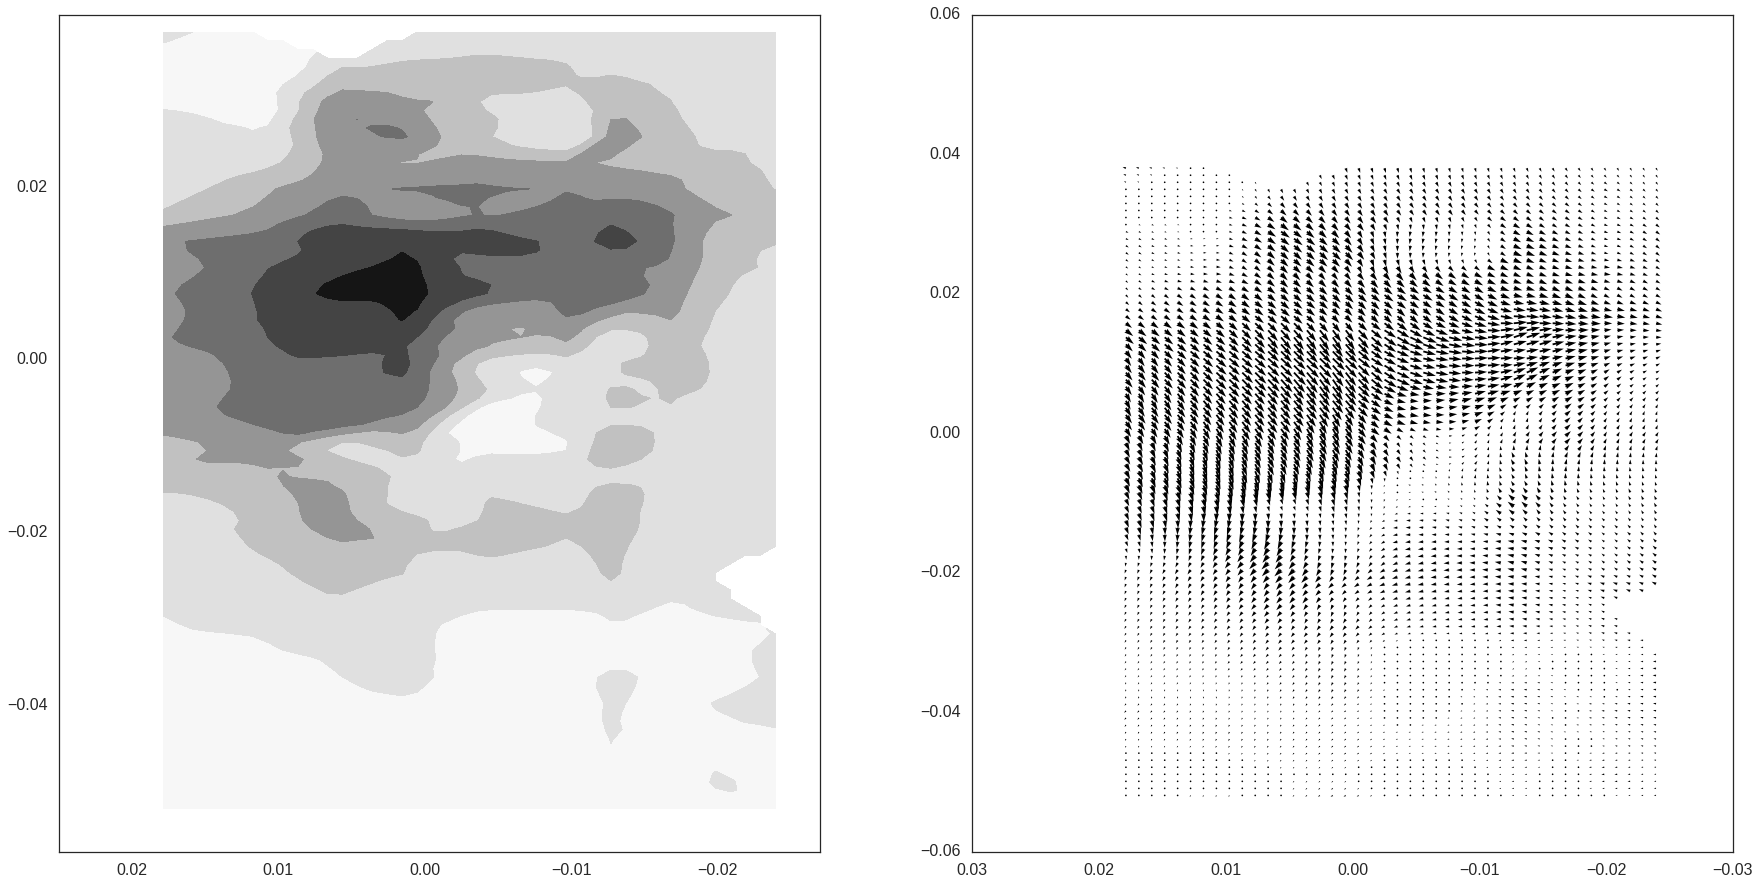

In [70]:
fig, axes = plt.subplots(1,2, figsize=(30, 15))
magnitude = np.sqrt(bx**2 + by**2)
axes[0].contourf(grid[0], grid[1], magnitude)
axes[1].quiver(grid[0], grid[1], bx, by)
axes[0].invert_xaxis()
axes[1].invert_xaxis()

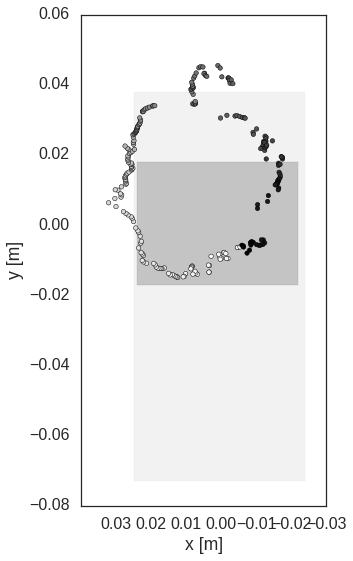

In [71]:
gyration_path(field_null_file='2017-04-12-10-09/field_nulls.txt')

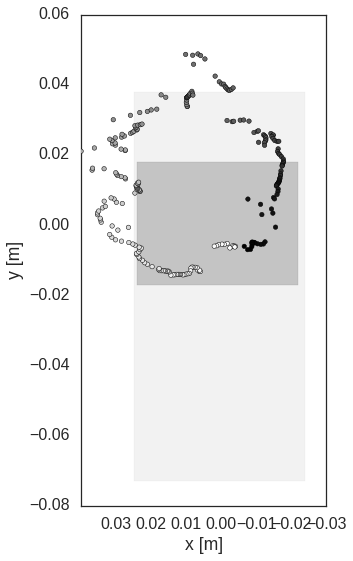

In [72]:
gyration_path(field_null_file='2017-04-17-18-49/field_nulls.txt')

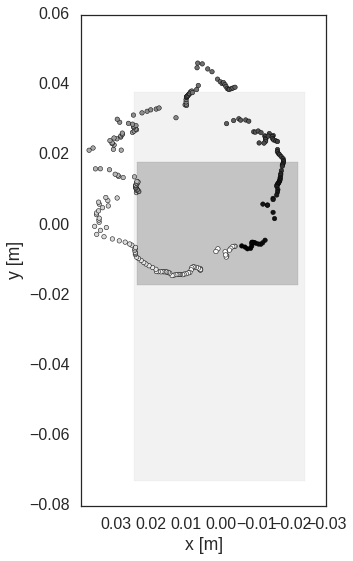

In [73]:
gyration_path(field_null_file='2017-04-17-19-00/field_nulls.txt')

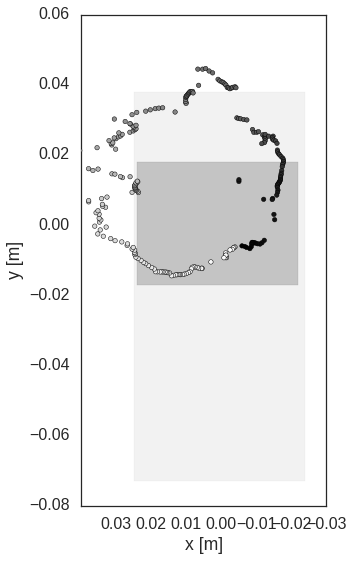

In [74]:
gyration_path(field_null_file='2017-04-17-19-12/field_nulls.txt')

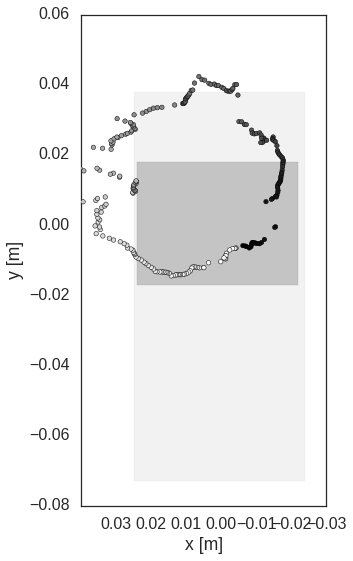

In [75]:
gyration_path(field_null_file='2017-04-17-19-22/field_nulls.txt')

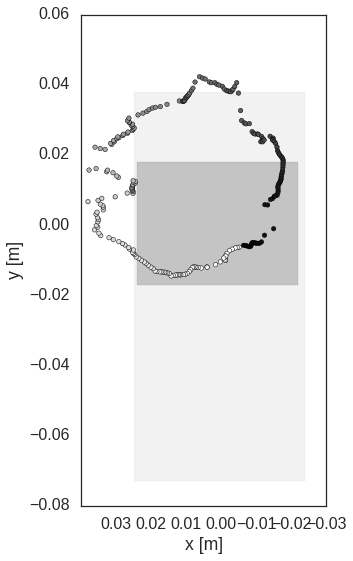

In [77]:
gyration_path(field_null_file='2017-04-17-19-42/field_nulls.txt')

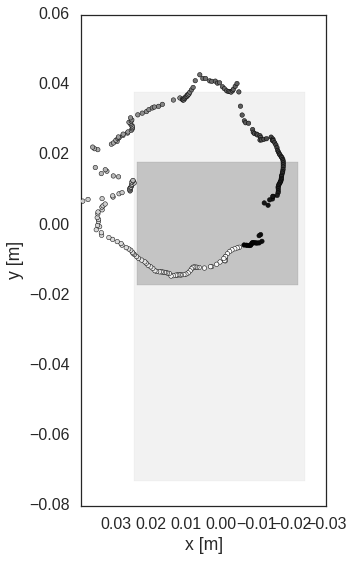

In [78]:
gyration_path(field_null_file='2017-04-17-19-48/field_nulls.txt')

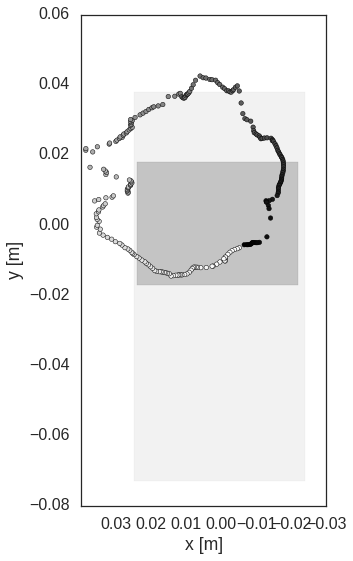

In [81]:
gyration_path(field_null_file='2017-04-17-19-56/field_nulls.txt')

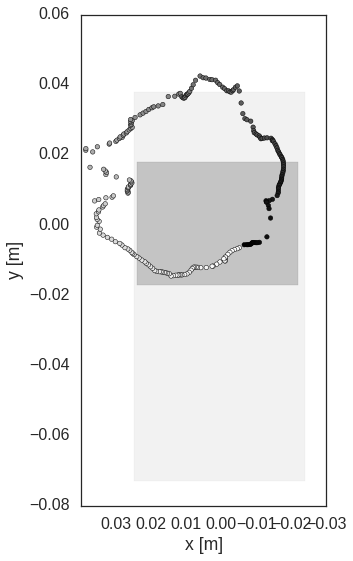

In [83]:
gyration_path(field_null_file='2017-04-17-19-56/field_nulls.txt')

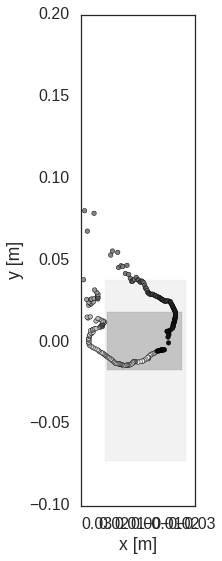

In [84]:
gyration_path(field_null_file='2017-04-17-20-04/field_nulls.txt')

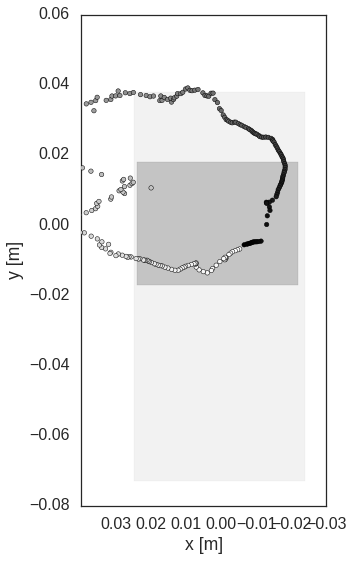

In [85]:
gyration_path(field_null_file='2017-04-17-20-09/field_nulls.txt')

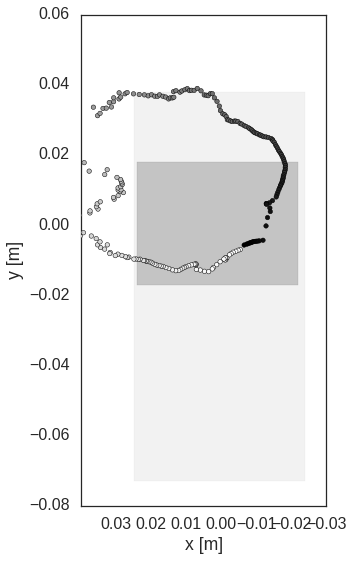

In [86]:
gyration_path(field_null_file='2017-04-17-20-14/field_nulls.txt')

In [193]:
field_null_directory = '/home/jensv/rsx/jens_analysis/output/field_nulls/' 
field_null_timestamps = ('2017-04-12-10-09',
                         '2017-04-17-18-49',
                         '2017-04-17-19-00',
                         '2017-04-17-19-12',
                         '2017-04-17-19-22',
                         '2017-04-17-19-42',
                         '2017-04-17-19-48', 
                         '2017-04-17-19-56',
                         '2017-04-17-20-04',
                         '2017-04-17-20-09',
                         '2017-04-17-20-14')
field_null_file = '/field_nulls.txt'

timestap = field_null_timestamps[0]
field_null_path = field_null_directory + timestamp + field_null_file
points = np.loadtxt(field_null_path)[:, :, np.newaxis]

for timestamp in field_null_timestamps[1:-1]:
    field_null_path = field_null_directory + timestamp + field_null_file
    points = np.append(points, np.loadtxt(field_null_path)[:, :, np.newaxis],
                       axis=2)
points_average = np.mean(points, axis=2)
points_std = np.std(points, axis=2, ddof=1)
    

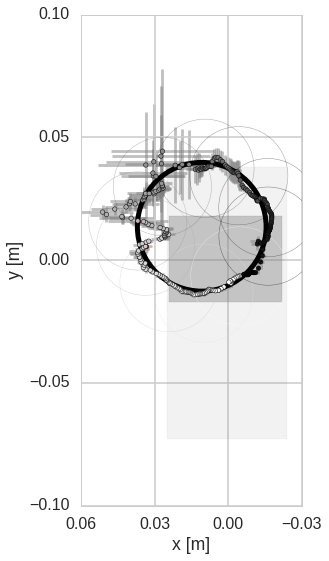

In [200]:
gyration_path(points=points_average, errors=points_std, errorevery=1,
              circle_fit=True, xlim=(-0.03, 0.06), circles=True, 
              xticks=[-0.03, 0.0, 0.03, 0.06])

In [ ]:
circle_params, success = leastsq(to_min, params_guess,
                                             args=np.asarray([streamline[:, 0],
                                                              streamline[:, 1]]))


In [105]:
def gyration_path(axes=None, circles=None, step=25, field_null_file=None, start=0, error_test=False):
    if field_null_file:
        centroid_file = field_null_file
    else:
        centroid_file = '/home/jensv/rsx/jens_analysis/output/field_nulls/2017-04-13-23-41/field_nulls.txt'
    field_nulls = np.loadtxt(centroid_file)

    x_min, x_max = -0.022, 0.024
    y_min, y_max = -0.017, 0.018

    if not axes:
        fig, axes = plt.subplots(1, 1)
    
    measurement_box = patches.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min,
                                    color='grey', alpha=0.4)

    
    bx_by_x_min = -0.024
    bx_by_x_max = 0.025
    bx_by_y_min = -0.073
    bx_by_y_max = 0.038
    bx_by_measurement_box = patches.Rectangle((bx_by_x_min, bx_by_y_min), 
                                              bx_by_x_max - bx_by_x_min,
                                              bx_by_y_max - bx_by_y_min,
                                              color='grey', alpha=0.1)
    
    
    axes.add_patch(measurement_box)
    axes.add_patch(bx_by_measurement_box)

    colormap = np.linspace(0, 1, 250-start)
    axes.scatter(field_nulls[start:, 0], field_nulls[start:, 1], c=colormap, zorder=100)
    if error_test:
        axes.errorbar(field_nulls[start:, 0], field_nulls[start:, 1], 
                      xerr=0.01, yerr=0.01, ecolor='grey', fmt='none', zorder=0, errorevery=10, alpha=0.5)
    

    axes.text(-0.008, -0.015, r'$0 \mu s$')
    axes.text(0.03, -0.003, r'$%2.1f \mu s$' % (0.068*56))
    axes.text(-0.03, 0.017, r'$%2.1f \mu s$' % (0.068*208))

    if circles:
        for i, field_null in enumerate(field_nulls[::step]):
            colormap = np.linspace(1, 0, np.round(250./step))
            circle = patches.Circle(field_null, radius=0.02, facecolor='none', 
                                    edgecolor=str(colormap[i]), alpha=0.5)
            axes.scatter(field_null[0], field_null[1], c='red')
            axes.add_patch(circle)
    axes.set_xlabel('x [m]')
    axes.set_ylabel('y [m]')
    axes.set_xlim(-0.03, 0.04)
    axes.set_aspect('equal')
    axes.invert_xaxis()
    return axes

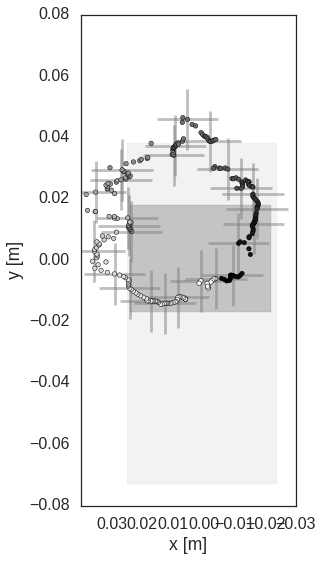

In [28]:
gyration_path(field_null_file='2017-04-13-23-41/field_nulls.txt', 
              error_test=True)